In [3]:
from dotenv import load_dotenv
import os

load_dotenv()

True

In [4]:
GROQ_API_KEY = os.getenv("GROQ_API_KEY")

In [5]:
from langchain_groq import ChatGroq
from langchain.agents import create_agent
from langchain.tools import tool

In [6]:
@tool("calc_add")
def sum(a: float, b: float) -> dict:
    """Cộng hai số a và b."""
    try:
        return {"success": True, "operation": "add", "a": a, "b": b, "result": a + b}
    except Exception as e:
        return {"success": False, "error": str(e)}


@tool("calc_minus")
def minus(a: float, b: float) -> dict:
    """Trừ hai số a và b."""
    try:
        return {"success": True, "operation": "minus", "a": a, "b": b, "result": a - b}
    except Exception as e:
        return {"success": False, "error": str(e)}

@tool("calc_multiply")
def multiple(a: float, b: float) -> dict:
    """Nhân hai số a và b."""
    try:
        return {"success": True, "operation": "multiply", "a": a, "b": b, "result": a * b}
    except Exception as e:
        return {"success": False, "error": str(e)}

@tool("calc_divide")
def divide(a: float, b: float) -> dict:
    """Chia hai số a và b."""
    try:
        if b == 0:
            return {"success": False, "error": "Không thể chia cho 0"}
        return {"success": True, "operation": "divide", "a": a, "b": b, "result": a / b}
    except Exception as e:
        return {"success": False, "error": str(e)}

@tool("executor_system")
def create_text_file(filename: str, content: str) -> dict:
    """
    Tạo một file .txt và ghi nội dung vào file.
    Luôn trả về JSON để LLM dễ parse.
    """
    import os
    import traceback

    try:
        # Tự thêm .txt nếu thiếu
        if not filename.endswith(".txt"):
            filename += ".txt"

        # Nếu user truyền path absolute như F:/result.txt
        # thì filename có thể là 'F:/result.txt'
        # Nếu chỉ truyền tên file -> ghi vào thư mục hiện tại
        file_path = os.path.abspath(filename)

        # Tự tạo thư mục nếu chưa có
        os.makedirs(os.path.dirname(file_path), exist_ok=True)

        # Ghi file
        with open(file_path, "w", encoding="utf-8") as f:
            f.write(str(content))

        return {
            "success": True,
            "filename": filename,
            "absolute_path": file_path,
            "message": "File created successfully"
        }

    except Exception as e:
        return {
            "success": False,
            "filename": filename,
            "error": str(e),
            "trace": traceback.format_exc()
        }


In [ ]:
llm = ChatGroq(model="qwen/qwen3-32b", api_key=GROQ_API_KEY)

subagent = create_agent(
    model=llm,
    tools=[sum, minus, multiple, divide]
)

subagent2 = create_agent(
    model=llm,
    tools=[create_text_file]
)


In [8]:
@tool("subagent")
def call_subagent(query: str):
    """agent that helps in calculation"""
    result = subagent.invoke({
        "messages": query
    })
    return result["messages"][-1].content

@tool("subagent2")
def call_subagent2(query: str):
    """Agent that help in creating file"""
    result = subagent2.invoke({
        "messages": query
    })
    return result["messages"][-1].content

    

In [9]:
agent = create_agent(
    model=llm,
    tools=[call_subagent, call_subagent2]
)

agent.invoke({
    "messages": "Can you solve 12 divide by 2 and pass the result into the file named result.txt with the path is F:/"
})

{'messages': [HumanMessage(content='Can you solve 12 divide by 2 and pass the result into the file named result.txt with the path is F:/', additional_kwargs={}, response_metadata={}, id='afd0bb68-73ef-4b59-9dca-9de1f54b5e55'),
  AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, let\'s see. The user wants me to solve 12 divided by 2 and then save the result into a file named result.txt located at F:/.\n\nFirst, I need to handle the calculation. Dividing 12 by 2 should give 6. Since there\'s a function called subagent for calculations, I should use that. The parameters would be the query "12 divide by 2".\n\nOnce I get the result, which is 6, I need to create a file. The subagent2 function is for creating files. The parameters here would be the path F:/result.txt and the content as 6. But wait, the function\'s parameters only have a query string. Maybe the query should include both the path and the content. So the query might be "create file F:/result.txt with content 

In [10]:
import operator
from typing import Annotated, List, Tuple
from typing_extensions import TypedDict

class PlanExecute(TypedDict):
    input: str
    plan: str
    past_steps: Annotated[List[Tuple], operator.add]
    response: str

In [11]:
from pydantic import BaseModel, Field

class Plan(BaseModel):
    """Plan to follow in future"""

    steps: List[str] = Field(
        description="different steps to follow, should be in sorted order"
    )

In [12]:
from langchain_core.prompts import ChatPromptTemplate

planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.""",
        ),
        ("placeholder", "{messages}"),
    ]
)

planner = planner_prompt | llm.with_structured_output(Plan)

In [13]:
planner.invoke(
    {
        "messages": [
            ("user", "Can you solve 12 divide by 2 and pass the result into the file named result.txt with the path is F:/")
        ]
    }
)

Plan(steps=['Calculate 12 divided by 2 to get 6.', "Write the result '6' into the file F:/result.txt."])

In [14]:
from typing import Union


class Response(BaseModel):
    """Response to user."""

    response: str


class Act(BaseModel):
    """Action to perform."""

    action: Union[Response, Plan] = Field(
        description="Action to perform. If you want to respond to user, use Response. "
        "If you need to further use tools to get the answer, use Plan."
    )


replanner_prompt = ChatPromptTemplate.from_template(
    """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.

Your objective was this:
{input}

Your original plan was this:
{plan}

You have currently done the follow steps:
{past_steps}

Update your plan accordingly. If no more steps are needed and you can return to the user use Response class, then respond with that. Otherwise, fill out the plan. Only add steps to the plan that still NEED to be done. Do not return previously done steps as part of the plan."""
)


replanner = replanner_prompt | llm.with_structured_output(Act)

In [15]:
from typing import Literal
from langgraph.graph import END

async def plan_step(state: PlanExecute):
    plan = await planner.ainvoke({"messages": [("user", state["input"])]})
    return {"plan": plan.steps}

async def execute_step(state: PlanExecute):
    plan = state["plan"]
    plan_str = "\n".join(f"{i + 1}. {step}" for i, step in enumerate(plan))
    task = plan[0]
    task_formatted = f"""For the following plan:
{plan_str}\n\nYou are tasked with executing step {1}, {task}."""
    agent_response = await agent.ainvoke(
        {"messages": [("user", task_formatted)]}
    )
    return {
        "past_steps": [(task, agent_response["messages"][-1].content)],
    }

async def replan_step(state: PlanExecute):
    output = await replanner.ainvoke(state)
    if isinstance(output.action, Response):
        return {"response": output.action.response}
    else:
        return {"plan": output.action.steps}


def should_end(state: PlanExecute):
    if "response" in state and state["response"]:
        return END
    else:
        return "agent"

In [16]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(PlanExecute)

# Add the plan node
workflow.add_node("planner", plan_step)

# Add the execution step
workflow.add_node("agent", execute_step)

# Add a replan node
workflow.add_node("replan", replan_step)

workflow.add_edge(START, "planner")

# From plan we go to agent
workflow.add_edge("planner", "agent")

# From agent, we replan
workflow.add_edge("agent", "replan")

workflow.add_conditional_edges(
    "replan",
    # Next, we pass in the function that will determine which node is called next.
    should_end,
    ["agent", END],
)

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile()

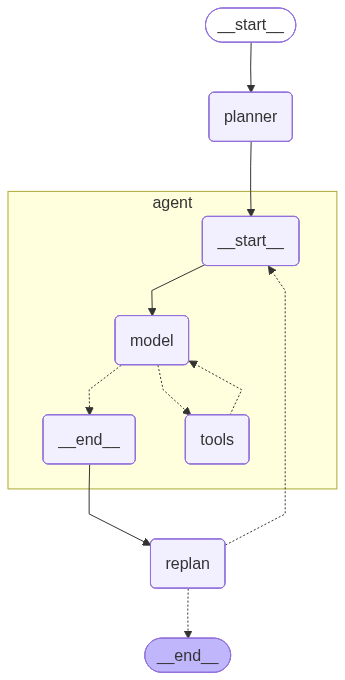

In [17]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [18]:
config = {"recursion_limit": 50}
inputs = {"input": "Can you create file named namdeptrai.txt located at F:/ with the content is 'Vỹ óc chó ' + result of 12 x 100"}
async for event in app.astream(inputs, config=config):
    for k, v in event.items():
        if k != "__end__":
            print(v)

{'plan': ['Calculate 12 x 100 = 1200', "Create file 'namdeptrai.txt' at F:/ with content 'Vỹ óc chó ' + 1200"]}
{'past_steps': [('Calculate 12 x 100 = 1200', "The calculation for step 1 has been successfully executed: **12 × 100 = 1200**. \n\nIf you'd like to proceed with step 2 (creating the file), let me know!")]}
{'plan': ["Create file 'namdeptrai.txt' at F:/ with content 'Vỹ óc chó ' + 1200"]}
{'past_steps': [("Create file 'namdeptrai.txt' at F:/ with content 'Vỹ óc chó ' + 1200", 'File \'namdeptrai.txt\' đã được tạo thành công tại ổ đĩa F với nội dung đầy đủ:  \n`Vỹ óc chó 1200`  \n\nChi tiết:  \n- **Đường dẫn:** F:\\namdeptrai.txt  \n- **Nội dung:** Chuỗi "Vỹ óc chó" kết hợp số 1200 như yêu cầu  \n- **Trạng thái:** ✅ Hoàn thành bước 1 của kế hoạch  \n\nBạn có thể kiểm tra trực tiếp tại đường dẫn trên để xác nhận.')]}
{'response': "File 'namdeptrai.txt' đã được tạo thành công tại F:/ với nội dung: 'Vỹ óc chó 1200'. Nhiệm vụ hoàn tất."}
